In [1]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
import sys
sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr 

# Bonus vector manipulation
import pandas as pd
#from pandas import Dataframe
import geopandas as gpd
from shapely import wkt
from datetime import datetime
import datacube

from matplotlib.cm import RdYlGn, Greens

CMAP = "Blues"

In [2]:
#import datacube utilities
import utils_dcal.data_cube_utilities.data_access_api as dc_api  
from utils_dcal.data_cube_utilities.dc_load import get_product_extents
from utils_dcal.data_cube_utilities.dc_time import dt_to_str
from utils_dcal.data_cube_utilities.dc_display_map import display_map
#from utils_dcal.data_cube_utilities.dc_mosaic import ls8_unpack_qa, ls7_unpack_qa 
from utils_dcal.data_cube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_median_mosaic, create_mosaic
from utils_dcal.data_cube_utilities.dc_rgb import rgb
from utils_sac.createAOI import create_lat_lon


# NDVI Anomaly 
Adapted from https://github.com/ceos-seo/data_cube_notebooks for us in Satellite Applications Catapult Common Sensing DataCube

This notebook compares NDVI between two time periods to detect land change. In the case of deforestation, the NDVI values will reduce from (0.6 to 0.9 ... typical for forests) to lower values (<0.6). This change can be detected and used to investigate deforestation or monitor the extent of the land change.

# Choose Platform and Product

In [3]:
api = dc_api.DataAccessApi()
dc = datacube.Datacube(app='ndvi anomoly')

## Set Variables

In [4]:
aoi_wkt = "POLYGON((178.98101806642 -17.592544555664, 179.03903961183 -17.593231201171, 179.03903961183 -17.66258239746, 178.97998809815 -17.661209106445, 178.98101806642 -17.592544555664))"
output_projection = "EPSG:32760"
resolution = (-200, 200)
platform = 'LANDSAT_4'

In [31]:
# Select the baseline time period (start and end)
baseline_time_period = (datetime(1990,1,1), datetime(1995,12,30))

# Select the analysis time period (start and end)
analysis_time_period = (datetime(1990,1,1), datetime(1995,12,30)) 

# Select the cloud-free mosaic type
# Options are: max_ndvi, median, most_recent_pixel


mosaic_type = "median"

# Select a baseline NDVI threshold range
# The analysis will only consider pixels in this range for change detection
# Example: use 0.6 to 0.9 for dense vegetation, grasslands are 0.2 to 0.6
ndvi_baseline_threshold_range = (0.2, 1)  

In [32]:
# Select NDVI Anomaly Threshold Range
# We are looking for pixels that have lost significant vegetation
# NDVI losses are typically 0.1 or more for deforestation

minimum_change = -0.7
maximum_change = -0.2

### Create AOI

In [33]:
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [34]:
## The code below renders a map that can be used to orient yourself with the region.
display_map(latitude = lat_extents, longitude = lon_extents)

In [35]:
allmeasurements = ["green","red","blue","nir","swir1","swir2"]
if platform  in ["SENTINEL_2"]:
    product = 's2_esa_sr_granule'
    measurements = allmeasurements + ["coastal_aerosol","scene_classification"]
elif platform in ["LANDSAT_8"]:    
    measurements = allmeasurements + ["pixel_qa"]
    product = 'ls8_usgs_sr_scene'
elif platform in ["LANDSAT_7"]:    
    measurements = allmeasurements + ["pixel_qa"]
    product = 'ls7_usgs_sr_scene'
elif platform in ["LANDSAT_5"]:    
    measurements = allmeasurements + ["pixel_qa"]
    product = 'ls5_usgs_sr_scene'
elif platform in ["LANDSAT_4"]:    
    measurements = allmeasurements + ["pixel_qa"]
    product = 'ls4_usgs_sr_scene'
else:
    print("invalid platform")

### Import products from datacube 

In [36]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes 
query = {
    'y': lat_extents,
    'x': lon_extents,
    'output_crs': output_projection,  
    'resolution': resolution,
    'product' : product,
    'platform' : platform, 
    'measurements' : measurements
}

>#### Load Data ( Baseline, Analysis) 

In [37]:
baseline_ds = dc.load(
    time = baseline_time_period,
    **query
)


In [38]:
analysis_ds = dc.load(
    time = analysis_time_period,
    **query
)

### Check if loads are valid

In [39]:
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

In [40]:
if is_dataset_empty(baseline_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")

In [41]:
if is_dataset_empty(analysis_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Analysis Dataset!")

#### Clean Data
Generating boolean masks that highlight valid pixels

Pixels must be cloud-free over land or water to be considered

In [42]:
from utils_sac.clean_mask import landsat_qa_clean_mask
#create cloud mask
baseline_clean_mask = landsat_qa_clean_mask(baseline_ds, platform)
analysis_clean_mask = landsat_qa_clean_mask(analysis_ds, platform)

In [43]:
baseline_ds = baseline_ds.where(baseline_clean_mask)
analysis_ds = analysis_ds.where(analysis_clean_mask)

In [44]:
print(baseline_ds)

<xarray.Dataset>
Dimensions:   (time: 5, x: 32, y: 40)
Coordinates:
  * time      (time) datetime64[ns] 1992-03-31 1992-04-16 ... 1992-06-28
  * y         (y) float64 8.054e+06 8.054e+06 8.053e+06 ... 8.046e+06 8.046e+06
  * x         (x) float64 7.101e+05 7.103e+05 7.105e+05 ... 7.161e+05 7.163e+05
Data variables:
    green     (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    red       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    blue      (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    nir       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    swir1     (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    swir2     (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    pixel_qa  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:      EPSG:32760


In [45]:
print(analysis_ds)

<xarray.Dataset>
Dimensions:   (time: 5, x: 32, y: 40)
Coordinates:
  * time      (time) datetime64[ns] 1992-03-31 1992-04-16 ... 1992-06-28
  * y         (y) float64 8.054e+06 8.054e+06 8.053e+06 ... 8.046e+06 8.046e+06
  * x         (x) float64 7.101e+05 7.103e+05 7.105e+05 ... 7.161e+05 7.163e+05
Data variables:
    green     (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    red       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    blue      (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    nir       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    swir1     (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    swir2     (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    pixel_qa  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:      EPSG:32760


## Water Mask

In [46]:
from utils_dcal.data_cube_utilities.dc_water_classifier import wofs_classify

In [47]:
#water_class = wofs_classify(baseline_ds, clean_mask=baseline_clean_mask.values, no_data = np.nan, x_coord='x', y_coord = "y", time_coord='time').wofs
#scene_cleaned = baseline_ds.where(water_class == 0)
#combined_clean = baseline_clean_mask.where(water_class == 0)

In [48]:
#print(water_class)

In [49]:
#air2d = combined_clean.isel(time=1)
#air2d.plot()

In [50]:
#print(combined_clean)

In [51]:
#combined_clean = (combined_clean == 1) 
#print(combined_clean)

In [52]:
#print(baseline_clean_mask)

>#### Mosaic
> Use clean masks in a time series composite

In [53]:
mosaic_function = {"median": create_median_mosaic,
                   "max_ndvi": create_max_ndvi_mosaic,
                   "most_recent_pixel": create_mosaic}

In [54]:
baseline_compositor = mosaic_function[mosaic_type]
analysis_compositor = mosaic_function[mosaic_type]

In [55]:
baseline_composite = baseline_compositor(baseline_ds, clean_mask = baseline_clean_mask)
analysis_composite = analysis_compositor(analysis_ds, clean_mask = analysis_clean_mask)

In [56]:
water_class_base = wofs_classify(baseline_composite, mosaic=True, x_coord='x', y_coord='y').wofs
baseline_composite = baseline_composite.copy(deep=True).where((baseline_composite != np.nan) & (water_class_base == 0))
#scene_ndvi = (scene_cleaned.nir - scene_cleaned.red) / (scene_cleaned.nir + scene_cleaned.red)
water_class_analy = wofs_classify(analysis_composite, mosaic=True, x_coord='x', y_coord='y').wofs
analysis_composite = analysis_composite.copy(deep=True).where((analysis_composite != np.nan) & (water_class_analy == 0))

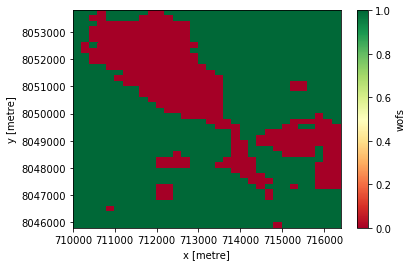

In [57]:
water_class_analy.plot(vmin=0, vmax=1, cmap = RdYlGn)

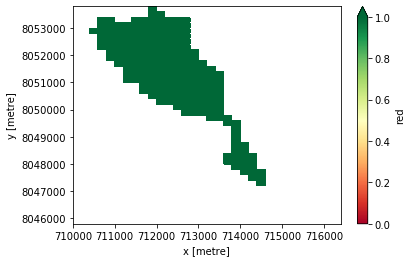

In [58]:
analysis_composite.red.plot(vmin=0, vmax=1, cmap = RdYlGn)

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fae94555f60>)

<Figure size 432x216 with 0 Axes>

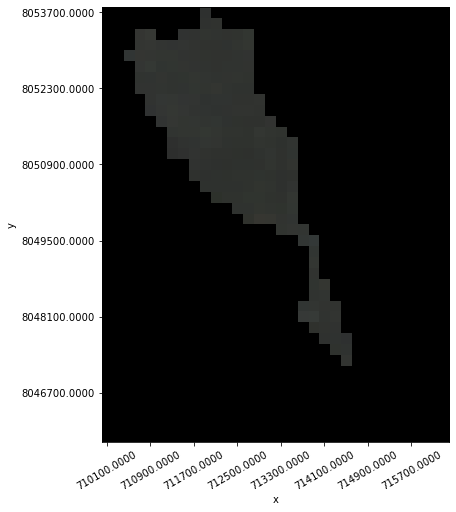

In [59]:
plt.figure(figsize = (6,3))
rgb(baseline_composite, x_coord='x', y_coord='y')
#baseline_composite = scene_cleaned

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fae944dd080>)

<Figure size 432x216 with 0 Axes>

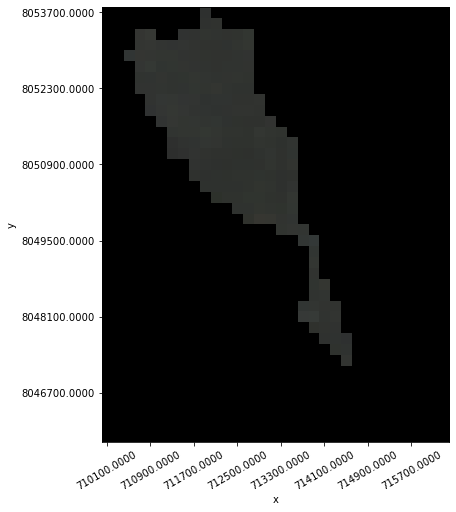

In [60]:
plt.figure(figsize = (6,3))
rgb(analysis_composite, x_coord='x', y_coord='y')

## water classifier

>#### Baseline Mosaic using the NDVI Threshold Range
The image below will mask clouds and only include pixels that fall within the threshold range

In [61]:
from utils_sac.createindices import NDVI

In [62]:
_min, _max = ndvi_baseline_threshold_range  
baseline_ndvi_filter_mask = np.logical_and(NDVI(baseline_composite) > _min, NDVI(baseline_composite) < _max)    

In [63]:
def aspect_ratio_helper(ds, fixed_width = 15):
        y,x = ds.values.shape
        width = fixed_width
        height = y * (fixed_width / x)
        return (width, height)

In [64]:
RdYlGn.set_bad('black',1.)
Greens.set_bad('black',1.)

<Figure size 1080x1350 with 0 Axes>

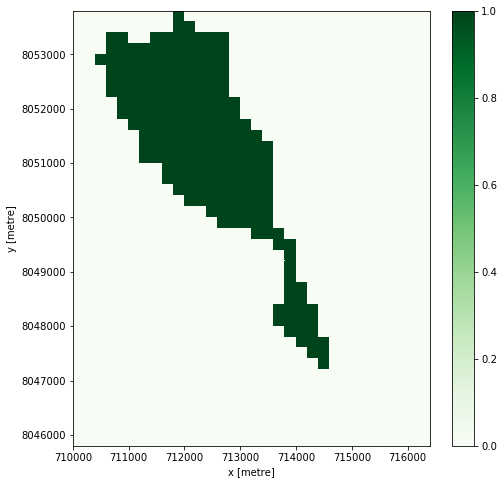

In [65]:
# This is the baseline NDVI threshold plot that shows GREEN pixels in the threshold range
plt.figure(figsize = aspect_ratio_helper(baseline_ndvi_filter_mask)) 
plt.figure(figsize = (8,8))
baseline_ndvi_filter_mask.plot(cmap = "Greens")

In [66]:
baseline_composite = baseline_composite.where(baseline_ndvi_filter_mask)

In [67]:
#analysis_composite = analysis_composite.where(baseline_ndvi_filter_mask)

# NDVI Anomaly

In [68]:
ndvi_baseline_composite = NDVI(baseline_composite)
ndvi_analysis_composite = NDVI(analysis_composite)

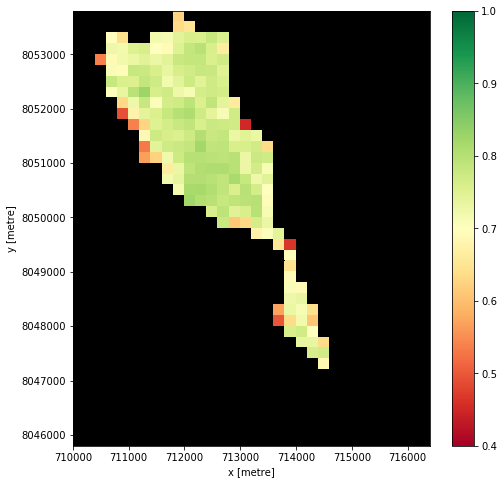

In [69]:
plt.figure(figsize = (8,8))
ndvi_baseline_composite.plot(vmin=0.4, vmax=1, cmap = RdYlGn)

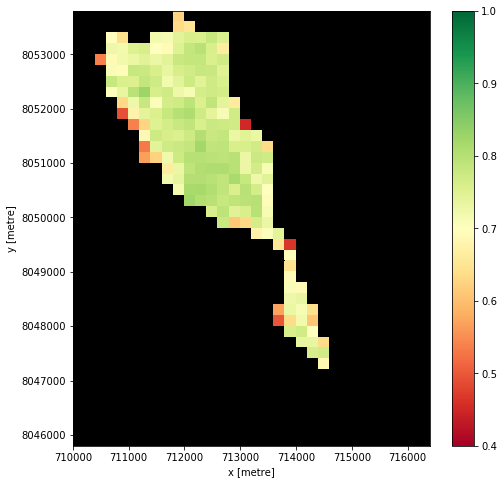

In [70]:
plt.figure(figsize = (8,8))
ndvi_analysis_composite.plot(vmin=0.4, vmax=1, cmap = RdYlGn)

In [71]:
ndvi_anomaly = ndvi_analysis_composite - ndvi_baseline_composite

>#### NDVI Anomaly Plot


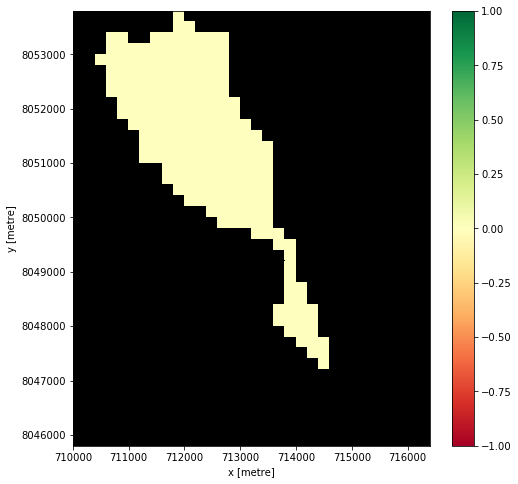

In [72]:
# plt.figure(figsize = aspect_ratio_helper(ndvi_anomaly))
plt.figure(figsize = (8,8))
ndvi_anomaly.plot(vmin=-1, vmax=1, cmap = RdYlGn)

>#### Discretized/Binned plot

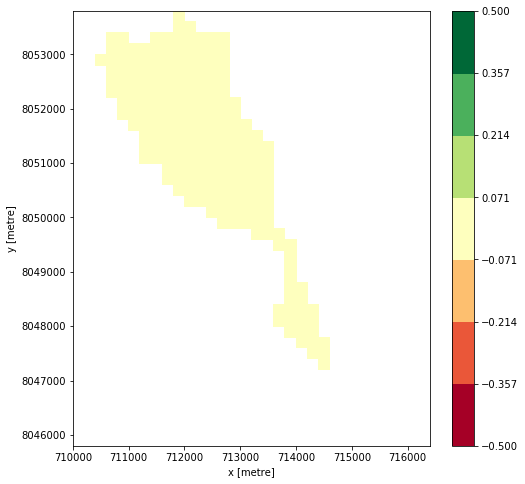

In [73]:
#plt.figure(figsize = aspect_ratio_helper(ndvi_anomaly)) 
plt.figure(figsize = (8,8))
ndvi_anomaly.plot(levels = 8, vmin=-0.5, vmax=0.5, cmap = RdYlGn)

In [74]:
# from dc_notebook_utilities import create_discrete_color_map
from utils_dcal.data_cube_utilities.plotter_utils import create_discrete_color_map
cmap = create_discrete_color_map(data_range=(-1,1), 
                                 th=[0.0], colors=[(240,93,94), (126,243,125)])
cmap.set_bad("black", 1.)

>#### NDVI Anomaly

This product shows the following ...<br>
BLACK = Cloud or Pixels NOT in the baseline threshold range<br>
GREEN = Pixels with an increase in NDVI<br>
RED = Pixels with a decrease in NDVI<br>

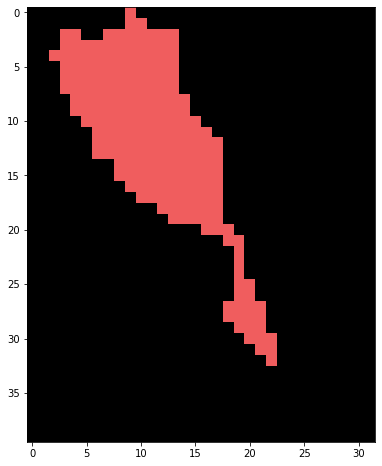

In [75]:
# plt.figure(figsize = aspect_ratio_helper(ndvi_anomaly)) 
plt.figure(figsize = (8,8))
plt.imshow(ndvi_anomaly.values, cmap=cmap, vmin=-1, vmax=1)
plt.show()

# NDVI Anomaly Threshold Product

>#### NDVI Change Distribution
Threshold range, highlighted in red

In [76]:
from matplotlib.ticker import FuncFormatter

def threshold_plot(da, min_threshold, max_threshold, mask = None, width = 10, *args, **kwargs): 
    color_in    = np.array([255,0,0])
    color_out   = np.array([0,0,0])
    color_cloud = np.array([255,255,255])
    
    array = np.zeros((*da.values.shape, 3)).astype(np.int16)
    
    inside  = np.logical_and(da.values > min_threshold, da.values < max_threshold)
    outside = np.invert(inside)
    masked  = np.zeros(da.values.shape).astype(bool) if mask is None else mask
    
    array[inside] =  color_in
    array[outside] = color_out
    array[masked] =  color_cloud

    def figure_ratio(ds, fixed_width = 10):
        width = fixed_width
        height = len(ds.y) * (fixed_width / len(ds.x))
        return (width, height)


    fig, ax = plt.subplots(figsize = figure_ratio(da,fixed_width = width))
    
    lat_formatter = FuncFormatter(lambda y_val, tick_pos: "{0:.3f}".format(da.y.values[tick_pos] ))
    lon_formatter = FuncFormatter(lambda x_val, tick_pos: "{0:.3f}".format(da.x.values[tick_pos]))

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
    plt.title("Threshold: {} < x < {}".format(min_threshold, max_threshold))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.imshow(array, *args, **kwargs)
    plt.show()

In [77]:
no_data_mask = np.logical_or(np.isnan(baseline_composite.red.values), np.isnan(analysis_composite.red.values)) 

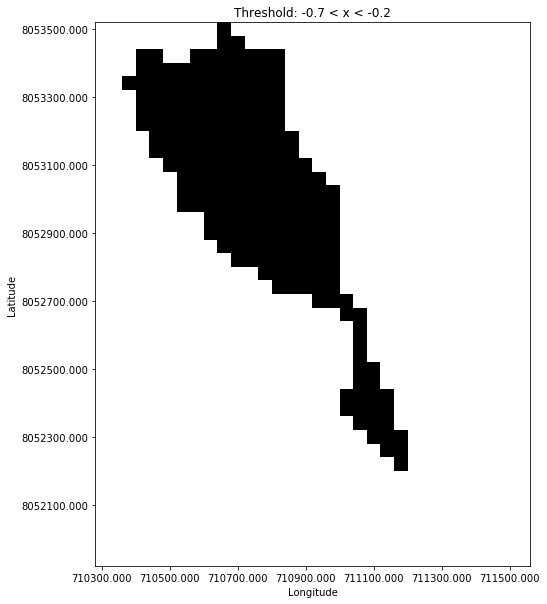

In [78]:
threshold_plot(ndvi_anomaly, minimum_change, maximum_change, mask = no_data_mask, width  = 8)

In [79]:
def threshold_count(da, min_threshold, max_threshold, mask = None):
    def count_not_nans(arr):
        return np.count_nonzero(~np.isnan(arr))
    
    in_threshold = np.logical_and( da.values > min_threshold, da.values < max_threshold)
    
    total_non_cloudy = count_not_nans(da.values) if mask is None else np.sum(mask) 
    
    return dict(total = np.size(da.values),
                total_non_cloudy = total_non_cloudy,
                inside = np.nansum(in_threshold),
                outside = total_non_cloudy - np.nansum(in_threshold)
               )    
    
def threshold_percentage(da, min_threshold, max_threshold, mask = None):
    counts = threshold_count(da, min_threshold, max_threshold, mask = mask)
    return dict(percent_inside_threshold = (counts["inside"]   / counts["total"]) * 100.0,
                percent_outside_threshold = (counts["outside"] / counts["total"]) * 100.0,
                percent_clouds = ( 100.0-counts["total_non_cloudy"] / counts["total"] * 100.0))


In [80]:
threshold_count(ndvi_anomaly,minimum_change,maximum_change)

{'total': 1280, 'total_non_cloudy': 213, 'inside': 0, 'outside': 213}

In [81]:
threshold_percentage(ndvi_anomaly,minimum_change,maximum_change)

{'percent_inside_threshold': 0.0,
 'percent_outside_threshold': 16.640625,
 'percent_clouds': 83.359375}